# Dependence of the depth
on the n. of frames and observables

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
from scipy.optimize import minimize

In [4]:
from Functions.basic_functions_bayesian import compute, compute_single
# from basic_functions_bayesian import local_density
# from basic_functions_bayesian import run_Metropolis, block_analysis

In [8]:
from Functions.basic_functions_gaussian import flatten, loss_fun, loss_and_grad, my_inv_erf
from Functions.basic_functions_gaussian import build_perimeter, compute_depth, compute_depth_analytical

ImportError: cannot import name 'compute_depth' from 'Functions.basic_functions_gaussian' (/home/ivang/Documenti/my_github/Jeffreys_prior/Functions/basic_functions_gaussian.py)

#### old...

In [ ]:
def loss_fun_old(lambdas, p0, g, gexp, sigma_exp, alpha, if_return_all = False):

    if len(g.shape) == 1: g = np.array([g])

    new_weights = p0*jnp.exp(-jnp.dot(lambdas, g))
    new_z = jnp.sum(new_weights)

    new_weights /= new_z

    av_g = jnp.dot(g, new_weights)
    print(av_g, new_z)
    chi2 = jnp.sum(((av_g - gexp)/sigma_exp)**2)
    # dkl = jnp.sum(new_weights*jnp.log(new_weights/p0))  # numerically unstable!!
    dkl = jnp.log(new_z) + jnp.dot(lambdas, av_g)
    print('dkl: ', dkl)
    loss_val = 1/2*chi2 + alpha*dkl
    
    if if_return_all: return loss_val, chi2, dkl, new_weights
    else: return loss_val

In [ ]:
class compute_depth_old():

    def __init__(self, n, sigma, gexp, sigma_exp, alpha, dim = 1, p0 = None, g = None):

        if dim == 1:

            p0 = np.ones(n)/n
            g = np.random.normal(0, sigma, size=n)

            x_min = np.argwhere(g == np.min(g))[0]
            x_max = np.argwhere(g == np.max(g))[0]

            self.gbar = np.max(g)
            
            self.lim_values = [-alpha*np.log(p0[x_max]) + 1/2*((np.max(g) - gexp)/sigma_exp)**2,
                -alpha*np.log(p0[x_min]) + 1/2*((np.min(g) - gexp)/sigma_exp)**2]

            dlambda = 1.0
            lambdamax = 100
            lambdas = np.arange(-lambdamax - dlambda, lambdamax + dlambda, dlambda)

            results = compute(lambdas, p0, g, gexp, sigma_exp, alpha)

            self.loss = results['lossf']
            self.lambdas = lambdas
            
            self.loss_min = np.min(results['lossf'])
            self.lambda_min = lambdas[np.argmin(results['lossf'])]
            self.avg_min = results['av_g'][np.argmin(results['lossf'])]

            self.lim_values_num = [results['lossf'][0], results['lossf'][-1]]
            
            self.dV = np.min(self.lim_values) - self.loss_min

        elif dim == 2:

            if p0 is None: p0 = np.ones(n)/n

            if g is None:
                if len(sigma.shape) == 1: cov = np.diag(sigma**2)
                else: cov = sigma
                
                g = np.random.multivariate_normal(mean=(0, 0), cov=cov, size=n).T

            lambdas = np.linspace(-70, 10, 100)

            # my_grid = np.meshgrid(lambdas, lambdas)

            out = {}

            for l1 in lambdas:
                out[l1] = {}
                for l2 in lambdas:
                    out[l1][l2] = vars(compute_single(np.array([l1, l2]), p0, g, gexp, sigma_exp, alpha))

            self.results = out

            flatten = lambda out, s: np.array([[out[l1][l2][s] for l1 in out.keys()] for l2 in out[l1].keys()])

            loss = flatten(out, 'lossf')
            avg = flatten(out, 'av_g')

            # np.unravel_index(np.argmin(loss, axis=None), loss.shape)
            self.loss_min = np.min(loss)

            wh = np.argwhere(loss == self.loss_min)[0]
            self.lambda_min = np.array([lambdas[wh[0]], lambdas[wh[1]]])
            self.avg_min = avg[wh[0], wh[1]]

            self.bar_value = np.min([np.min(loss[0]), np.min(loss[-1]), np.min(loss[:, 0]), np.min(loss[:, -1])])

            wh = np.argwhere(loss == self.bar_value)[0]
            self.bar_g = avg[wh[0], wh[1]]

            self.bar_chi2 = np.sum(((self.bar_g - gexp)/sigma_exp)**2)

            self.dV = self.bar_value - self.loss_min



## 1-dimensional (single observable)

### distribution of the biggest value extracted from a Gaussian distribution

https://math.stackexchange.com/questions/473229/expected-value-of-maximum-and-minimum-of-n-normal-random-variables

https://math.stackexchange.com/questions/89030/expectation-of-the-maximum-of-gaussian-random-variables

In [6]:
sigma = 0.5

2
3
4
5
6


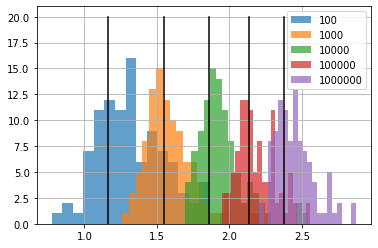

In [9]:
log_ns = np.arange(2, 7, 1)

my_hists = {}
vals = []  # the estimated average/mode value
vals2 = []

for log_n in log_ns:
    print(log_n)
    
    n = int(10**log_n)

    vals.append(sigma*my_inv_erf(1 - 2/n))
    # vals2.append(sigma*np.sqrt(2*np.log(n)))

    my_values = []

    for i in range(100):
        g = np.random.normal(0, sigma, size=n)
        my_values.append(np.max(g))

    # plt.plot(my_list, '.')
    # plt.figure()
    my_hists[n] = plt.hist(my_values, bins=20, alpha=0.7, label=n)

    plt.plot([vals[-1], vals[-1]], [0, 20], '-k')
    # plt.plot([vals2[-1], vals2[-1]], [0, 20], '--k')

plt.grid()
plt.legend()

$\bar g(N)$ vs. $\log N$

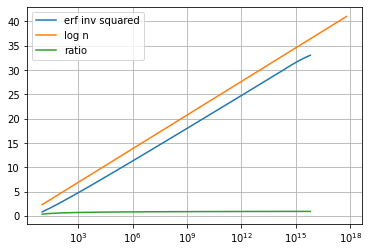

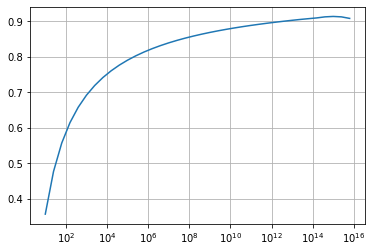

In [23]:
log_ns = np.arange(1, 18, 0.4)
ns = 10**log_ns

a = erfinv(1 - 2/ns)**2
b = np.log(ns)

plt.plot(ns, a, label='erf inv squared')
plt.plot(ns, b, label='log n')
plt.plot(ns, a/b, label='ratio')


plt.legend()
plt.xscale('log')
plt.grid()

plt.figure()
plt.plot(ns, a/b, label='ratio')
plt.xscale('log')
# plt.yscale('log')
plt.grid()

#### difference 1st 2nd maxima

/tmp/ipykernel_12988/3973809843.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.int(1e4)


0.17972598473813736 0.0016509147008884068


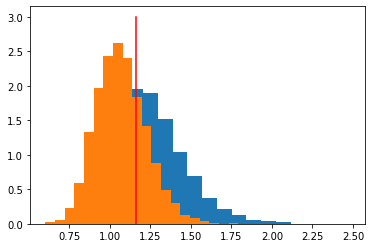

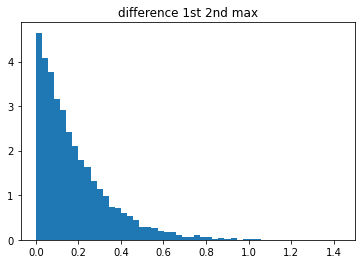

In [10]:
n = 100

val = sigma*my_inv_erf(1 - 2/n)

my_max = []
my_2ndmax = []
my_diff = []

m = np.int(1e4)

for i in range(m):
    g = np.random.normal(0, sigma, size=n)
    my_max.append(np.max(g))
    my_2ndmax.append(np.max(np.array(list(set(g) - set([np.max(g)])))))
    my_diff.append(my_max[-1] - my_2ndmax[-1])



my_hists = plt.hist(my_max, bins=20, density=True)
plt.plot([val, val], [0, 3], '-r')

plt.hist(my_2ndmax, bins=20, density=True)

plt.figure()
plt.title('difference 1st 2nd max')
plt.hist(my_diff, bins=50, density=True)

print(np.mean(my_diff), np.std(my_diff)/np.sqrt(m))

### scan over n

In [11]:
alpha = 1

In [12]:
sigma = 0.2
gexp = 0.15
sigma_exp = 0.08

log_ns = np.linspace(1, 6, 100)
ns = np.unique(np.array([int(10**log_n) for log_n in log_ns]))

out1 = {}
out2 = {}

for n in ns:
    print(n)
    
    out1[n] = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100)
    out2[n] = compute_depth_analytical(n, sigma, gexp, sigma_exp, alpha)

10


NameError: name 'compute_depth' is not defined

In [26]:
vars(out2[n]).keys()

dict_keys(['lambda_min', 'avg_min', 'loss_min', 'gbar', 'lim_chi2', 'lim_dkl', 'lim_value', 'dV'])

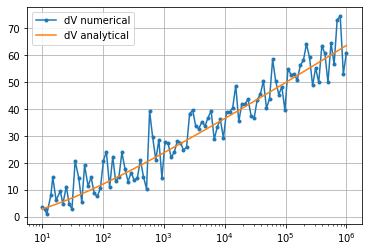

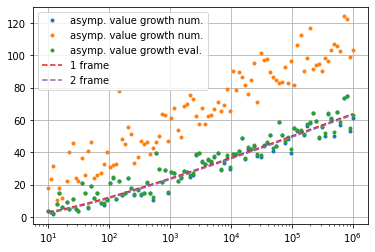

In [27]:
ns = np.array(list(out1.keys()))

plt.plot(ns, flatten(out1, 'dV'), '.-', label='dV numerical')
plt.plot(ns, flatten(out2, 'dV'), '-', label='dV analytical')

# plt.plot(ns, alpha*np.log(ns), '--', label='alpha logN')

ns = np.array(ns)
# plt.plot(ns, 1/2*(sigma/sigma_exp*my_inv_erf(1 - 2/ns))**2, '--', label='gbar growth')
# g_bar_growth = 1/2*((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2
# plt.plot(ns, g_bar_growth, '--', label='g bar growth')

# plt.plot(ns, [out2[n].lim_value - out1[n].min_loss for n in ns], label='dV growth')

plt.xscale('log')
plt.legend()
plt.grid()

plt.figure()
plt.plot(ns, [out1[n].lim_loss_num for n in ns], '.', label='asymp. value growth num.')
plt.plot(ns, [out1[n].lim_loss[0] for n in ns], '.', label='asymp. value growth eval.')

plt.plot(ns, alpha*np.log(ns) + 1/2*((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2, '--', label='1 frame')
plt.plot(ns, alpha*np.log(ns/2) + 1/2*((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2, '--', label='2 frame')


plt.xscale('log')
plt.legend()
plt.grid()

there is a small contribution from other frames different from the bar one: so, the ensemble is slightly closer to the original one (smaller dkl) whereas the chi2 is almost constant; with 2 frames it is

$D_{KL} \rightarrow log(N/2)$

$\chi^2 \rightarrow \chi^2(1 frame)$

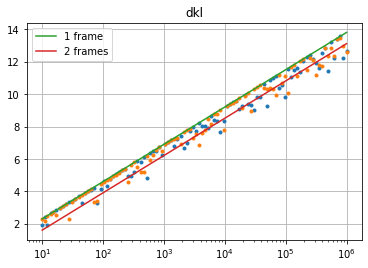

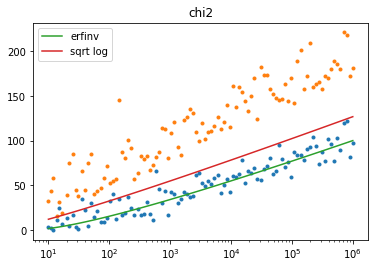

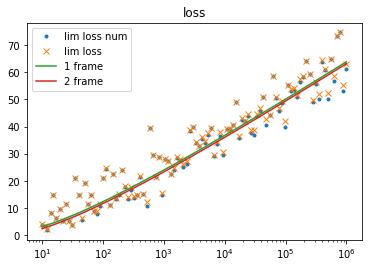

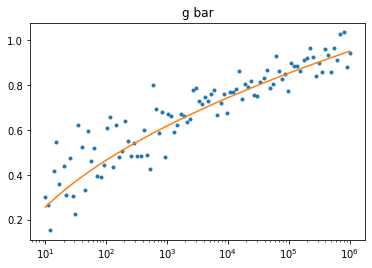

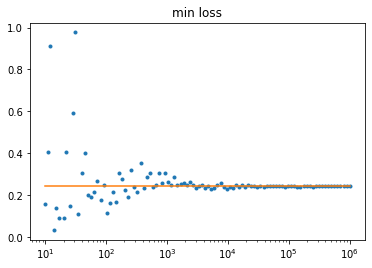

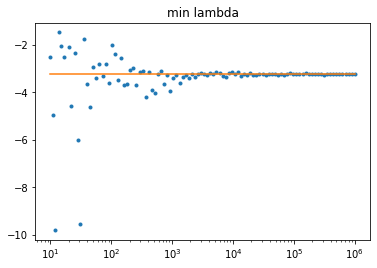

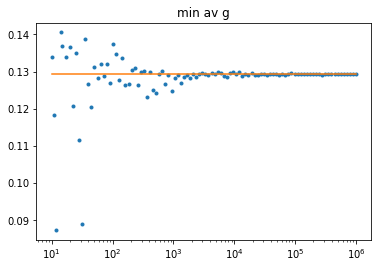

In [31]:
plt.plot(ns, flatten(out1, 'lim_dkl'), '.')
plt.plot(ns, np.log(ns), label='1 frame')
plt.plot(ns, np.log(ns/2), label='2 frames')
plt.grid()
plt.legend()
plt.title('dkl')
plt.xscale('log')

plt.figure()
plt.plot(ns, flatten(out1, 'lim_chi2'), '.')
plt.plot(ns, ((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2, label='erfinv')
plt.plot(ns, ((sigma*np.sqrt(2*np.log(ns)) - gexp)/sigma_exp)**2, label='sqrt log')
plt.legend()
plt.title('chi2')
plt.xscale('log')

plt.figure()
plt.plot(ns, [out1[n].lim_loss_num[0] for n in out1.keys()], '.', label='lim loss num')
plt.plot(ns, [out1[n].lim_loss[0] for n in out1.keys()], 'x', label='lim loss')
# plt.plot(ns, np.array(flatten(out1, 'lim_dkl'))[:, 0] + 1/2*np.array(flatten(out1, 'lim_chi2'))[:, 0], '.', label='sum')
plt.plot(ns, alpha*np.log(ns) + 1/2*((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2, label='1 frame')
plt.plot(ns, alpha*np.log(ns/2) + 1/2*((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2, label='2 frame')


plt.legend()
plt.title('loss')
plt.xscale('log')

plt.figure()
plt.plot(ns, flatten(out1, 'gbar'), '.')
plt.plot(ns, flatten(out2, 'gbar'))
plt.title('g bar')
plt.xscale('log')

plt.figure()
plt.plot(ns, flatten(out1, 'min_loss'), '.')
plt.plot(ns, flatten(out2, 'loss_min'), '-')
plt.title('min loss')
plt.xscale('log')

plt.figure()
plt.plot(ns, flatten(out1, 'min_lambda'), '.')
plt.plot(ns, flatten(out2, 'lambda_min'), '-')
plt.title('min lambda')
plt.xscale('log')

plt.figure()
plt.plot(ns, flatten(out1, 'min_avg'), '.')
plt.plot(ns, flatten(out2, 'avg_min'), '-')
plt.title('min av g')
plt.xscale('log')

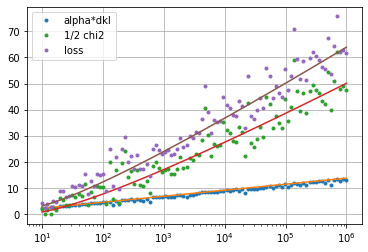

In [55]:
plt.plot(ns, alpha*flatten(out1, 'lim_dkl', 0), '.', label='alpha*dkl')
est_adkl = alpha*np.log(ns)
plt.plot(ns, est_adkl)  # , label='1 frame')

# plt.plot(ns, np.log(ns/2), label='2 frames')
est_chi2 = ((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2
plt.plot(ns, 1/2*np.array(flatten(out1, 'lim_chi2', 0)), '.', label='1/2 chi2')
plt.plot(ns, 1/2*est_chi2)

plt.plot(ns, np.array(flatten(out1, 'lim_loss', 0)), '.', label='loss')
plt.plot(ns, est_adkl + 1/2*est_chi2)



plt.legend()
plt.xscale('log')
plt.grid()

In [86]:
n = 100
res = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=100, if_scan=True)

In [79]:
vars(res).keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV', 'scan_lambdas', 'scan_results', 'scan_loss_min', 'scan_lambda_min', 'scan_avg_min'])

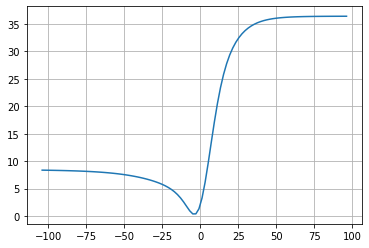

In [87]:
plt.plot(res.scan_lambdas, res.scan_results['lossf'], '-')
plt.grid()

In [70]:
from basic_functions_bayesian import run_Metropolis

In [91]:
p0 = np.ones(n)/n

energy_function = lambda x : np.array([loss_fun(x, p0, res.g, gexp, sigma_exp, alpha)])
out_Metropolis = run_Metropolis(np.zeros(1), 0.3, energy_function, n_steps=50000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [92]:
out_Metropolis[2]

0.96328

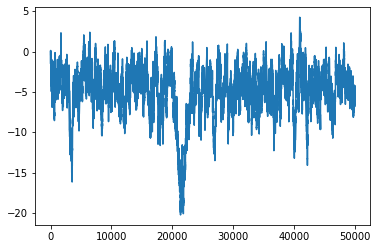

In [93]:
plt.plot(out_Metropolis[0])

aumenta il n. di frame mettendo la correlazione (il chi2 andrà a una costante, non sto aggiungendo informazione nuova); è come avere punti raddoppiati, quindi il chi2 sarà uguale

quindi traiettoria "continua", il termine dkl dominerà

quindi campiono più frequentemente?

raddoppio il n. di frame (cioè ne metto in mezzo) e ricalcolo dkl; se campiono più spesso il contributo dkl cambia

In [15]:
vars(out1[n]).keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV'])

30.10033
5.347116


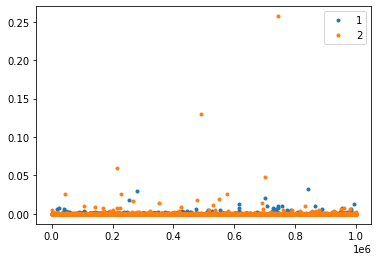

In [16]:
g = np.random.normal(0, sigma, n)
p0 = np.ones(n)/n

result = loss_fun(out1[n].min_lambda + 50, p0, g, gexp, sigma_exp, alpha, True)
plt.plot(result[-1], '.', label='1')
print(result[1])

result = loss_fun(out1[n].min_lambda - 50, p0, g, gexp, sigma_exp, alpha, True)
plt.plot(result[-1], '.', label='2')
print(result[1])

plt.legend()

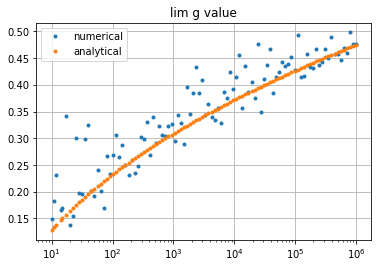

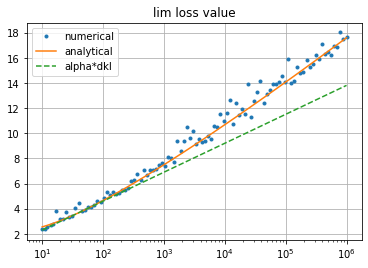

In [17]:
plt.plot(ns, [out1[n].gbar for n in out1.keys()], '.', label='numerical')
plt.plot(ns, [out2[n].gbar for n in out2.keys()], '.', label='analytical')
plt.xscale('log')
plt.title('lim g value')
plt.legend()
plt.grid()

plt.figure()
plt.plot(ns, [out1[n].lim_loss[0] for n in out1.keys()], '.', label='numerical')
plt.plot(ns, flatten(out2, 'lim_value'), '-', label='analytical')
# analitical is:
# plt.plot(ns, alpha*np.log(ns) + 1/2*((sigma*my_inv_erf(1 - 2/ns) - gexp)/sigma_exp)**2, '--')
plt.plot(ns, alpha*np.log(ns), '--', label='alpha*dkl')
plt.title('lim loss value')
plt.xscale('log')
plt.legend()
plt.grid()

griglia più fitta, o ripeti tot volte a fissato N

plot chi2 ed entropia relativa

## 2-dimensional

In [13]:
alpha = 1

In [14]:
sigma = np.array([0.05, 0.05])
gexp = np.array([0.15, 0.15])
sigma_exp = np.array([0.15, 0.15])

In [15]:
n = 20000

p0 = np.ones(n)/n
g = np.random.multivariate_normal(np.zeros(2), np.diag(sigma**2), n).T

### single case study

0.0003788522517081082
[0.16655291 0.1397602 ]
ratio:  1.1917048601367808


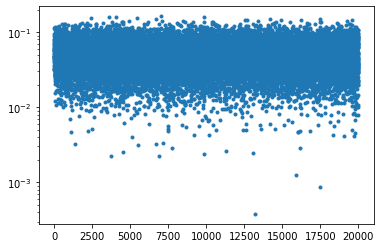

In [16]:
ds = (g[0, :] - gexp[0])**2 + (g[1, :] - gexp[1])**2

plt.plot(ds, '.')
print(np.min(ds))
plt.yscale('log')

wh1 = np.where(ds == np.min(ds))[0][0]
bar_g = g[:, wh1]

print(bar_g)
print('ratio: ', bar_g[0]/bar_g[1])

move in the direction such that the limit distribution is 1 in the closest frame to the experimental value and zero elsewhere

In [17]:
lambdas = -bar_g*1e4

res = loss_fun(lambdas, p0, g, gexp, sigma_exp, alpha, True)

(Array(9.911861, dtype=float32), Array(0.01683787, dtype=float32), Array(9.903442, dtype=float32)) 9.903487552536127
[0.16655291 0.1397602 ]
ratio:  1.1917048601367808


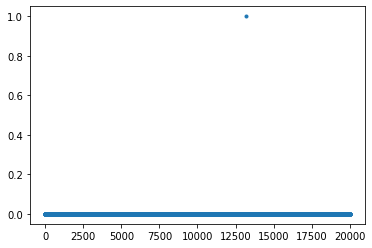

In [18]:
plt.plot(res[-1], '.')
print(res[:-1], np.log(n))

wh2 = np.where(res[-1] == np.max(res[-1]))[0][0]

print(g[:, wh2])
print('ratio: ', g[0, wh2]/g[1, wh2])


0.0003788522517081082


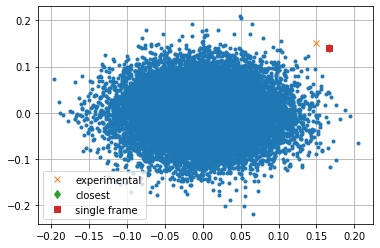

In [19]:
plt.plot(g[0], g[1], '.')
plt.plot(gexp[0], gexp[1], 'x', label='experimental')

plt.plot(g[0][wh1], g[1][wh1], 'd', label='closest')
plt.plot(g[0][wh2], g[1][wh2], 's', label='single frame')

ds2 = (g[0][wh2] - gexp[0])**2 + (g[1][wh2] - gexp[1])**2

print(ds2)

plt.grid()
plt.legend(loc='lower left')

In [20]:
from Functions.basic_functions_gaussian import distances_nd

In [21]:
result = distances_nd(p0, g, gexp, sigma_exp, alpha)

vars(result).keys()

print(result.ds0, result.ds2, result.min_ds)

0.22820233700371031 0.019464127304045977 0.019464127304045977


In [22]:
d_fun = lambda n, sigma : np.sqrt(2*np.log(n))*sigma[0]

print(d_fun(n, sigma))

my_vals = d_fun(n/4, sigma)

dexp = np.linalg.norm(gexp)
print(my_vals, dexp, my_vals - dexp)


0.222525139619506
0.206363674024963 0.21213203435596426 -0.005768360331001254


In [23]:
print('biggest distance from the origin: ', result.ds0, d_fun(n, sigma))
print('distance selected frame - exp. value: ', result.ds2, np.abs(d_fun(n/4, sigma) - dexp))

biggest distance from the origin:  0.22820233700371031 0.222525139619506
distance selected frame - exp. value:  0.019464127304045977 0.005768360331001254


the expected distance from the origin of the farthest point is
$\sim d_{max}(N) := \sqrt{2\log(N)}\sigma$

while the distance between the selected frame and the experimental value is estimated as
$\sim |d_{max}(N/4) - |\vec g_{exp}||$ (factor 1/4 because only the same quadrant of gexp matters, abs. value because gexp can be closer or further, depending on sigma)

let's see if it is a good estimate on different range of n. of frames

- the variable `log_ns` is in base 10

In [24]:
log_ns = np.linspace(2, 6, 20)

out = {}

for log_n in log_ns:
    n = np.int64(10**log_n)
    p0 = np.ones(n)/n
    g = np.random.multivariate_normal(np.zeros(2), np.diag(sigma**2), n).T

    out[n] = distances_nd(p0, g, gexp, sigma_exp, alpha)


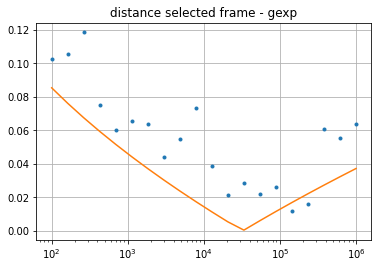

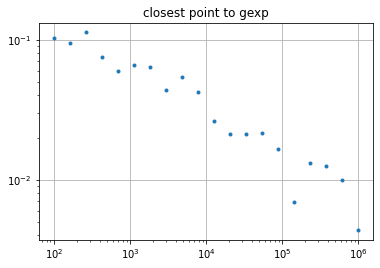

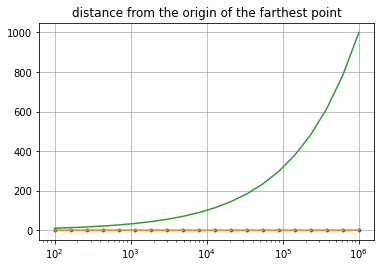

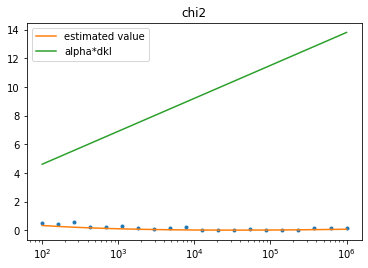

In [26]:
ns = 10**log_ns
my_vals = np.sqrt(2*np.log(ns/4))*sigma[0]
dexp = np.linalg.norm(gexp)
my_vals0 = np.sqrt(2*np.log(ns))*sigma[0]
exp_chi2 = (my_vals - dexp)**2/sigma_exp[0]**2

plt.plot(ns, [out[n].ds2 for n in out.keys()], '.')
plt.plot(ns, np.abs(my_vals - dexp))
plt.xscale('log')
plt.title('distance selected frame - gexp')
plt.grid()

plt.figure()
plt.plot(ns, [np.min(out[n].ds) for n in out.keys()], '.')
plt.xscale('log')
plt.yscale('log')
plt.title('closest point to gexp')
plt.grid()

plt.figure()
plt.plot(ns, [out[n].ds0 for n in out.keys()], '.')
plt.plot(ns, my_vals0)
plt.plot(ns, np.sqrt(ns))
plt.xscale('log')
plt.title('distance from the origin of the farthest point')
plt.grid()

plt.figure()
plt.plot(ns, [out[n].chi2 for n in out.keys()], '.')
plt.plot(ns, exp_chi2, label='estimated value')
plt.plot(ns, alpha*np.log(ns), label='alpha*dkl')
plt.title('chi2')
plt.xscale('log')
plt.legend()

### repeat with different n. of frames

In [70]:
out = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=25)

vars(out)

{'g': array([[-0.10040014,  0.01659064, -0.0389886 , ..., -0.01586416,
         -0.7483412 ,  0.32476266],
        [-0.01914142, -0.3593891 , -0.22735011, ...,  0.22121688,
         -0.4388797 , -0.04775253]]),
 'mini':       fun: 1.2591397762298584
  hess_inv: array([[5.06753622, 0.25039074],
        [0.25039074, 4.84191783]])
       jac: array([-2.3841858e-07,  6.4074993e-07], dtype=float32)
   message: 'Optimization terminated successfully.'
      nfev: 10
       nit: 9
      njev: 10
    status: 0
   success: True
         x: array([-5.06455487, -5.01839537]),
 'min_lambda': array([-5.06455487, -5.01839537]),
 'min_loss': 1.2591397762298584,
 'min_avg': array([0.19935438, 0.19981597]),
 'perim_losses': array([21.926474, 21.817652, 21.703625, 21.585144, 21.463268, 21.339327,
        21.215055, 21.092396, 20.973541, 20.860998, 20.75727 , 20.664925,
        20.586308, 20.523521, 20.478317, 20.451748, 20.444286, 20.455807,
        20.485449, 20.5318  , 20.59277 , 20.666058, 20.749054, 

In [101]:
results = []

log_ns = np.linspace(1, 5, 50)
ns = np.unique(np.array([int(10**log_n) for log_n in log_ns]))

for n in ns:
    print(n)
    results.append(compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=500))


10
12
14
17
21
25
30
37
44
54
65
79
95
115
138
167
202
244
294
355
429
517
625
754
910
1098
1325
1599
1930
2329
2811
3393
4094
4941
5963
7196
8685
10481
12648
15264
18420
22229
26826
32374
39069
47148
56898
68664
82864
100000


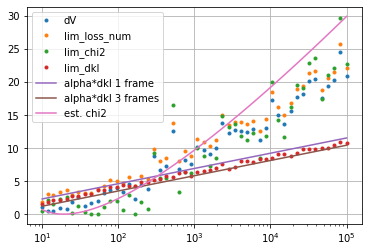

In [102]:
my_list = ['dV', 'lim_loss_num', 'lim_chi2', 'lim_dkl']

for s in my_list:
    plt.plot(ns, flatten(results, s), '.', label=s)

plt.plot(ns, alpha*np.log(ns), label='alpha*dkl 1 frame')
plt.plot(ns, alpha*np.log(ns/3), label='alpha*dkl 3 frames')
plt.plot(ns, (np.sqrt(2*np.log(ns/4))*sigma[0] - np.linalg.norm(gexp))**2/sigma_exp[0]**2, label='est. chi2') 

plt.xscale('log')
plt.grid()
# plt.title('dV')

plt.legend()

In [63]:
lambdas1 = list(out.results.keys())
lambdas2 = list(out.results[lambdas1[0]].keys())

loss = [[out.results[l1][l2] for l2 in lambdas2] for l1 in lambdas1]


plt.pcolormesh(lambdas1, lambdas2, loss, cmap='jet')
plt.colorbar()

AttributeError: 'compute_depth' object has no attribute 'results'

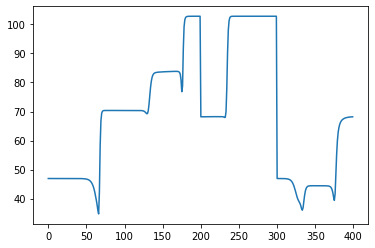

In [67]:
plt.plot(out.perim_losses)

In [13]:
n = 100

out = compute_depth(n, sigma, gexp, sigma_exp, alpha, delta_lambda=25)  # , if_scan=True)


[42.380024 42.339252 42.298763 ... 57.385464 57.41002  57.434883]
3411


[0.25 0.25]


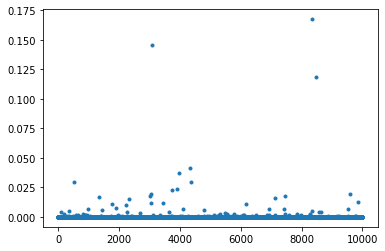

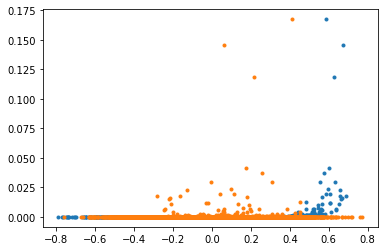

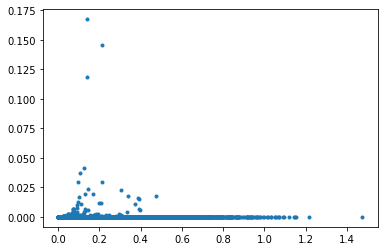

In [14]:
plt.plot(out.lim_p, '.')

plt.figure()
plt.plot(out.g[0, :], out.lim_p, '.')
plt.plot(out.g[1, :], out.lim_p, '.')

plt.figure()
diff = np.sum((out.g.T - gexp)**2, axis=1)

plt.plot(diff, out.lim_p, '.')
print(gexp)

In [83]:
vars(out).keys()

dict_keys(['g', 'mini', 'min_lambda', 'min_loss', 'min_avg', 'perim_losses', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'lim_p', 'dV'])

[0.25 0.25]


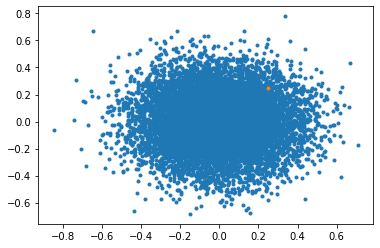

In [153]:
plt.plot(out.g[0], out.g[1], '.')
plt.plot(gexp[0], gexp[1], '.')
print(gexp)

In [156]:
ds = (out.g[0, :] - gexp[0])**2 + (out.g[1, :] - gexp[1])**2
# ds = np.sum(np.einsum('ij,i->ij', out.g, -gexp)**2, axis=0)  # WRONG

wh = np.where(ds == np.min(ds))[0][0]

chi2 = np.sum((out.g[:, wh] - gexp)/sigma_exp)**2
print(chi2)

lim_loss = alpha*np.log(n) + 1/2*chi2

print(lim_loss)


5.372587519130044e-07
46.0517021285103


In [155]:
print(out.lim_chi2, out.lim_dkl, out.lim_loss_num)



2.311106 1.3151741 7.7314234


/u/i/igilardo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


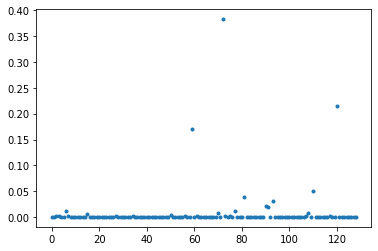

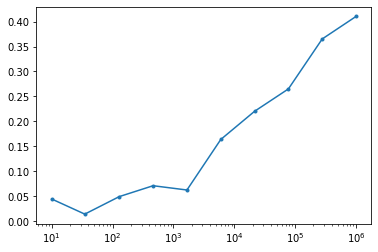

In [61]:
lim_p = flatten(results, 'lim_p')
g = flatten(results, 'g')

plt.plot(lim_p[2], '.')

opt_g = np.stack((g[i][:, np.where(lim_p[i] == np.max(lim_p[i]))[0][0]] for i in range(len(g))))

plt.figure()
# plt.plot(ns, [opt_g[i][0][0] for i in range(len(opt_g))], '.-')
# plt.plot(ns, [opt_g[i][1][0] for i in range(len(opt_g))], '.-')
ds = np.sum((opt_g - gexp)**2, axis=1)
plt.plot(ns, ds, '.-')


plt.xscale('log')

## repeat in different dimensionality

In [10]:
from basic_functions_gaussian import distances_nd, my_inv_erf

In [8]:
alpha = 1

In [9]:
n = 100000
dim = 2

sigma = 0.2
gexp = 0.15*np.ones(dim)
sigma_exp = 0.05*np.ones(dim)

p0 = np.ones(n)/n
sigma = sigma*np.ones(dim)
g = np.random.multivariate_normal(np.zeros(dim), np.diag(sigma**2), n).T


out = distances_nd(p0, g, gexp, sigma_exp, alpha)

#### cycle both over n. of frames and dimension

In [65]:
# ns = [10, 100, 1000, 10000, 100000, 1000000]
log_ns = np.arange(1, 6, 1)
ns = 10**log_ns
dims = np.arange(1, 30, 1)

outs = {}

for n in ns:
    
    n = np.int64(n)
    outs[n] = []

    for dim in dims:

        dim = np.int64(dim)
        gexp = 0.15*np.ones(dim)
        sigma_exp = 0.05*np.ones(dim)

        p0 = np.ones(n)/n
        sigma = 0.2*np.ones(dim)
        g = np.random.multivariate_normal(np.zeros(dim), np.diag(sigma**2), n).T

        outs[n].append(distances_nd(p0, g, gexp, sigma_exp, alpha))


Text(0.5, 0, 'dim')

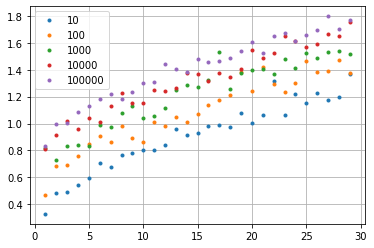

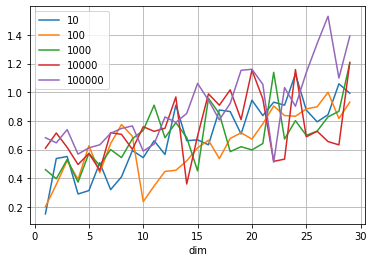

In [66]:
for n in ns:
    n = np.int64(n)
    plt.plot(dims, flatten(outs[n], 'ds0'), '.', label=n)
plt.legend()
plt.grid()

plt.figure()
for n in ns:
    n = np.int64(n)
    plt.plot(dims, flatten(outs[n], 'ds2'), '-', label=n)
plt.legend()
plt.grid()
plt.xlabel('dim')

#### cycle over n. of frames at given dim

In [40]:
log_ns = np.linspace(1, 6, 100)
ns = 10**log_ns

dim = 1

outs = []

for n in ns:

    n = np.int64(n)
    dim = np.int64(dim)
    gexp = 0.15*np.ones(dim)
    sigma_exp = 0.05*np.ones(dim)

    p0 = np.ones(n)/n
    sigma = 0.2*np.ones(dim)
    g = np.random.multivariate_normal(np.zeros(dim), np.diag(sigma**2), n).T

    outs.append(distances_nd(p0, g, gexp, sigma_exp, alpha))

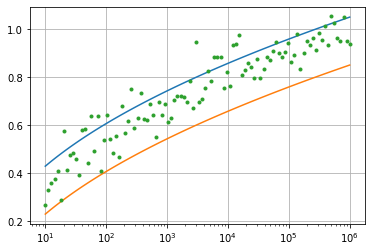

In [41]:
ds0 = flatten(outs, 'ds0')

ns = np.array(ns)
plt.plot(ns, sigma[0]*(dim + 1)/2*np.sqrt(2*np.log(ns)))
plt.plot(ns, sigma[0]*((dim + 1)/2*np.sqrt(2*np.log(ns)) - dim))
# plt.plot(ns, sigma[0]*my_inv_erf(1 - 2/ns))
plt.plot(ns, ds0, '.')

plt.xscale('log')
plt.grid()

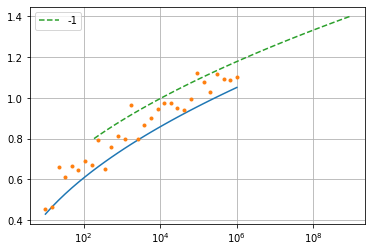

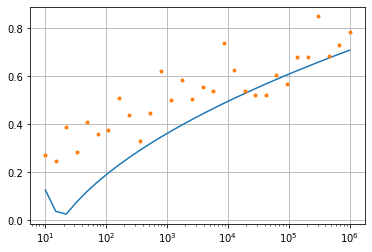

In [119]:
ds0 = flatten(outs, 'ds0')

ns = np.array(ns)
plt.plot(ns, sigma[0]*np.sqrt(2*np.log(ns)))
# plt.plot(ns, sigma[0]*np.sqrt(2)*my_inv_erf(1 - 2/ns))
plt.plot(ns, ds0, '.')

xs = np.linspace(0.8, 1.4, 100)
my_ns = 1/((xs/sigma[0])**(dim - 1)*np.exp(-xs**2/(2*sigma[0]**2)))
plt.plot(my_ns, xs, '--', label='-1')

# my_ns = 1/(((xs/sigma[0])**(dim - 2) + 6*(xs/sigma[0])**(dim - 4) + 24*(xs/sigma[0])**(dim - 6) + 48)*np.exp(-xs**2/(2*sigma[0]**2)))
# plt.plot(my_ns, xs, '--', label='-2')

plt.plot
plt.xscale('log')
plt.grid()
plt.legend()

plt.figure()

ds2 = flatten(outs, 'ds2')

dexp = np.linalg.norm(gexp)
ns = np.array(ns)
plt.plot(ns, np.abs(sigma[0]*np.sqrt(2*(np.log(ns/(2**dim)))) - dexp))
# plt.plot(ns, np.abs(sigma[0]*np.sqrt(2*(np.log(ns))) - dexp))
plt.plot(ns, ds2, '.')
# plt.plot(ns, alpha*np.log(ns), '--')
plt.xscale('log')
plt.grid()

### ...

In [66]:
mins = []
lims = []
chi2s = []

log_ns = np.arange(1, 6, 1)
ns = [np.int(10**x) for x in log_ns]

for n in ns:
    print(n)
    
    p0 = np.ones(n)/n

    if len(sigma.shape) == 1: cov = np.diag(sigma**2)
    else: cov = sigma

    g = np.random.multivariate_normal(mean=(0, 0), cov=cov, size=n).T

    lambdas = jnp.array([0.0, 0.0])

    out = compute_depth(n, sigma, gexp, sigma_exp, alpha, 2, p0=p0, g=g)
    mins.append(out.loss_min)
    lims.append(out.bar_value)
    chi2s.append(out.bar_chi2)

10


TypeError: __init__() got an unexpected keyword argument 'p0'

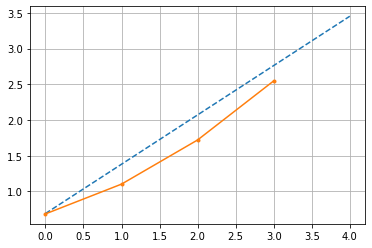

In [66]:
plt.plot(alpha*np.log(ns), '--')
plt.plot(np.array(lims) - 1/2*np.array(chi2s), '.-')
# plt.xscale('log')
plt.grid()

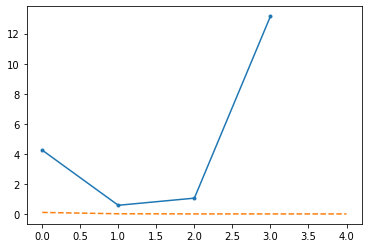

In [67]:
plt.plot(chi2s, '.-')
plt.plot(1/np.array(ns), '--')

In [55]:
print(mins, lims, chi2s, np.array(lims) - 1/2*np.array(chi2s))

alpha*np.log(ns)

[3.019160496829529, 1.0713366327362703, 0.9932424295561144, 1.1139923175281643] [3.0197478600060577, 1.5643887057260304, 3.123429959850925, 5.412577708472768] [4.7206010440889115, 0.8871812753667846, 2.5903840957802187, 5.69010224893856] [0.65944734 1.12079807 1.82823791 2.56752658]


array([0.69077553, 1.38155106, 2.07232658, 2.76310211, 3.45387764])

Text(0.5, 1.0, 'min values')

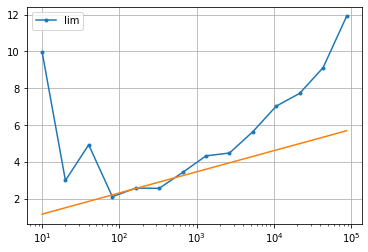

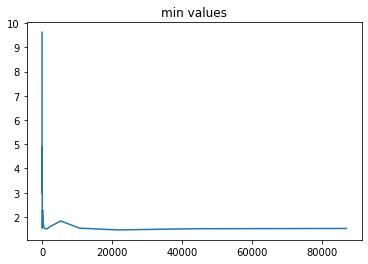

In [162]:
x = ns[::6][:len(mins)]

# plt.plot(x, mins, '-', label='min')
plt.plot(x, lims, '.-', label='lim')
# plt.plot(x, np.array(lims) - np.array(mins), '-', label='dV')
# plt.plot(x, alpha*np.log(x) - mins, '.-')
# plt.plot(x, alpha*np.log(x) + 10/x)
plt.plot(x, alpha*np.log(x))


plt.legend()
plt.grid()
plt.xscale('log')

plt.figure()
plt.plot(x, mins)
plt.title('min values')

In [166]:
vars(out)

KeyboardInterrupt: 

TypeError: 'compute_depth' object does not support indexing

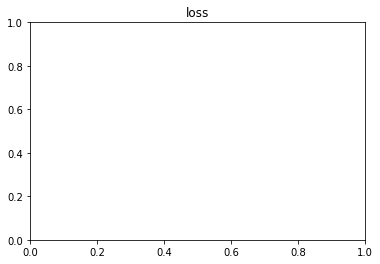

In [163]:
plt.title('loss')
plt.pcolormesh(out[0], out[0], flatten(out[1], 'lossf'), cmap='jet')
plt.colorbar()

In [130]:
alpha*np.log(n)

4.144653167389282

In [129]:
out[-1]

34.8396489897268

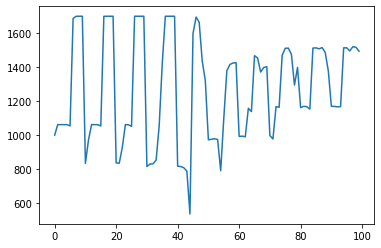

In [66]:
plt.plot(flatten(out, 'lossf'))